#  Using Image Pyramid for Image Blending
Student Name: Gökçenaz Akyol

Student No: b2200765030

## Background

Image blending is one of the most essential tasks in image editing software like Adobe Photoshop and GIMP and is used for a variety of tasks. For instance, you may create a poster for a movie or an advertisement. The main goal of picture blending techniques is to mix images seamlessly. In other words, seams where images or image portions are stitched together must be undetectable for an image blending method to work. Two or more photos can be blended in a variety of ways. One such strategy was put forward in the [1] Laplacian Pyramid. According to this methodology, photos are first divided into their Laplacian pyramids, and these images are then seamlessly mixed in pyramid levels.

# Initialization
In this part of the assignment, we will import necessary libraries and initialize.

In [1]:
# import necessary libraries
import cv2
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from matplotlib import image
import os
import glob
from PIL import Image

# adjust the size of figures
plt.rcParams['figure.figsize'] = (5.0, 5.0)

### Defining Methods
- As we will see in the experiments, images can have different shapes and objects can have different locations that we want to change in order to blend them with different images.
- In order to adjust these differencies, we need to define some method that will help us.

In [2]:
def image_resizing(img, size):
  
  """
    Resize the images with the parameter size.
  """

  new_img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)

  return new_img


In [3]:
def image_padding(img, _height, _width):

  """
    Add paddings to image in order to make images size's same to apply image blending.
  """

  y, x, c = img.shape

  # create mask that is fully black
  new_img = np.full((_height, _width, c), (0,0,0), dtype=np.uint8)

  # find the midpoint of original image 
  xc = (_width - x) // 2
  yc= (_height - y) // 2

  # padding
  new_img[yc:yc+y, xc:xc+x] = img

  return new_img


# Image Blending 
- In this part of the project, we will define a class which consist of some methods that will help image blending operations.

In [168]:
class ImageBlending():

  """

    Image blending with Laplacian Pyramid is a method used in image processing to
    seamlessly and artistically integrate two images. The procedure entails breaking
    down each image into a pyramid of its component elements before combining the 
    pyramids to form a brand-new composite image. 

  """

  def laplacian_pyramid(self, pyr):

    """
      This method takes the difference between a down-sampled version of an image
      and an up-sampled version of the image at the next level of the pyramid. 
    """

    pyramid = []
    pyramid.append(pyr[-1])
    
    # range
    rng = len(pyr) - 1

    for i in range(rng):

        # sizes
        x = pyr[rng - i - 1].shape[1]
        y = pyr[rng - i - 1].shape[0]

        layer = cv2.pyrUp(pyr[rng - i], dstsize=(x,y))

        # takes the difference
        laplacian = np.subtract(pyr[rng - i -1], layer)

        pyramid.append(laplacian)

    return pyramid


  def gaussian_pyramid(self, img, depth):

    """
      This method repeatedly smoothes an image and down-samples it, resulting in 
      a series of increasingly low-resolution images. 
    """

    pyramid = []
    pyramid.append(img)

    for i in range(depth):
      
      # down-sampling
      img = cv2.pyrDown(img)
      pyramid.append(np.float32(img))

    return pyramid


  def blend(self, laplacian_1,laplacian_2,region):

    """
      Using a region mask from the same level, combine each pyramid layer with 
      this formula: Li12 = Li1.Ri + Li2.(1 − Ri)
    """

    blended = []
    rng = len(laplacian_1)

    for i in range(rng):

      # uses the formula for each level
      blended_layer = laplacian_1[i] * region[i] + laplacian_2[i] * (1 - region[i])
      blended.append(blended_layer)

    return blended

  def crate_image_pyramid(self, blended):

    """
      This method starts at the top of the pyramid and successively up-samples 
      and adds each layer to the next, until the original image size is reached.
    """
    
    new_image = []
    new_image.append(blended[0])
    rng = len(blended) - 1

    top = blended[0]

    for i in range(rng):

        # sizes
        x = blended[i + 1].shape[1]
        y = blended[i + 1].shape[0]

        # up-sampling and adding
        layer = cv2.pyrUp(top, dstsize=(x,y))
        top = cv2.add(blended[i+1], layer)
        new_image.append(top)

    return new_image 

  def create_image(self, img1, img2, mask, depth):

    """
      This method uses all the methods above and creates the new image.
    """

    ib = ImageBlending()

    # image 1
    img1_gaussian = ib.gaussian_pyramid(img1, depth)
    img1_laplacian = ib.laplacian_pyramid(img1_gaussian)

    # image 2
    img2_gaussian = ib.gaussian_pyramid(img2, depth)
    img2_laplacian = ib.laplacian_pyramid(img2_gaussian)

    # creating mask
    mask = ib.gaussian_pyramid(mask, depth)
    mask.reverse()

    # blending images
    blended = ib.blend(img1_laplacian, img2_laplacian, mask)

    # create new image
    new_image  = ib.crate_image_pyramid(blended)
    new_image = np.array(new_image)

    return new_image

In [169]:
ib = ImageBlending()

# Experiments
- In this part of the assignment, will define different masks to specify different regions for every pyramid.
- There will be 5 experiments. In every experiment, we will try to apply the object/texture in the first image to second image.
- Masks are specified before with the help of masking.py file. You can check these codes and also videos to see how to create specific masks for every experiment.

## Experiment 1: Brain and Heart

In [173]:
# read brain image
brain = cv2.imread("drive/MyDrive/images/brain.jpg")
brain = cv2.cvtColor(brain, cv2.COLOR_BGR2RGB)
brain = cv2.resize(np.array(brain[:500, :]), (860, 910), interpolation = cv2.INTER_AREA)

In [174]:
# read heart image
heart = cv2.imread("drive/MyDrive/images/heart.png")
heart = cv2.cvtColor(heart, cv2.COLOR_BGR2RGB)

In [176]:
# read the heart mask
heart_mask = cv2.imread("drive/MyDrive/images/heart_mask.jpg")
heart_mask = image_resizing(heart_mask[:855,60:],(860,910))

### Try Image Blending Operations with different Depth Levels


<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


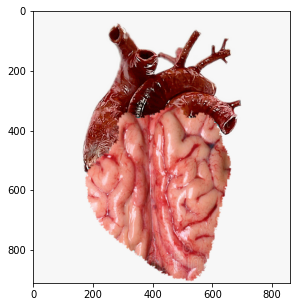

In [179]:
# Depth 1
new_img = ib.create_image(brain, heart, heart_mask//255, 1)
plt.imshow(((new_img[1])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


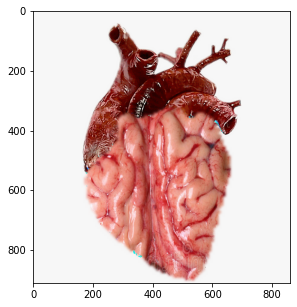

In [177]:
# Depth 3
new_img = ib.create_image(brain, heart, heart_mask//255, 3)
plt.imshow(((new_img[3])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


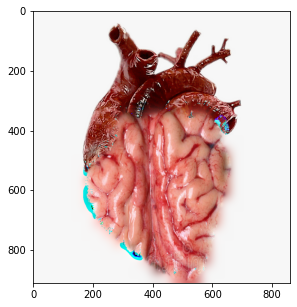

In [180]:
# Depth 5
new_img = ib.create_image(brain, heart, heart_mask//255, 5)
plt.imshow(((new_img[5])).astype(np.uint8));

## Experiment 2: Dog and Grass

In [181]:
# read dog image
dog = cv2.imread("drive/MyDrive/images/dog.jpg")
dog = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
dog = image_resizing(dog, (800,435))
dog = image_padding(dog, 640, 1080)

In [182]:
# read grass image
grass = cv2.imread("drive/MyDrive/images/grass.jpg")
grass = cv2.cvtColor(grass, cv2.COLOR_BGR2RGB)

In [190]:
# read dog mask
dog_mask = cv2.imread("drive/MyDrive/images/dog_mask.jpg")

### Try Image Blending Operations with different Depth Levels

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


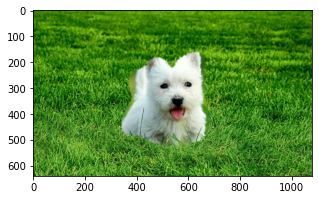

In [185]:
# Depth 2
new_img = ib.create_image(dog, grass, dog_mask//255, 2)
plt.imshow(((new_img[2])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


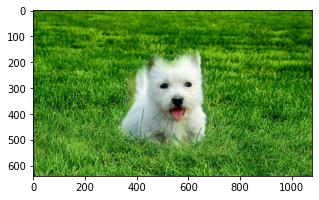

In [184]:
# Depth 5
new_img = ib.create_image(dog, grass, dog_mask//255, 5)
plt.imshow(((new_img[5])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


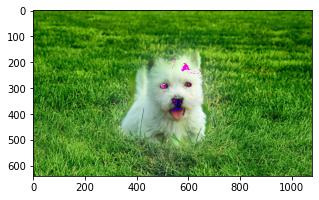

In [187]:
# Depth 7
new_img = ib.create_image(dog, grass, dog_mask//255, 7)
plt.imshow(((new_img[7])).astype(np.uint8));

## Experiment 3: Strawberry and Apple

In [188]:
# read strawberry image
strawberry = cv2.imread("drive/MyDrive/images/strawberry.jpg")
strawberry = cv2.cvtColor(strawberry, cv2.COLOR_BGR2RGB)
strawberry = image_resizing(strawberry[200:490, 100:500], (612, 612))

In [189]:
# read apple image
apple = cv2.imread("drive/MyDrive/images/apple.jpg")
apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB)

In [191]:
# read apple mask image
apple_mask = cv2.imread("drive/MyDrive/images/apple_mask.jpg")
apple_mask = image_resizing(apple_mask[:,30:605],(612,612))

### Try Image Blending Operations with different Depth Levels

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


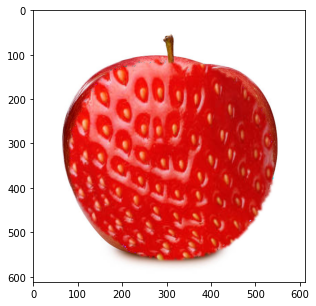

In [193]:
# Depth 2
new_img = ib.create_image(strawberry, apple, apple_mask//255, 2)
plt.imshow(((new_img[2])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


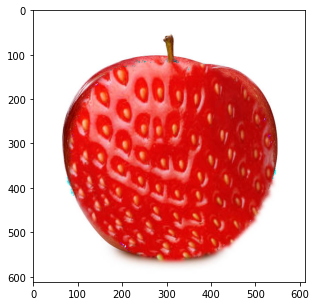

In [192]:
# Depth 3
new_img = ib.create_image(strawberry, apple, apple_mask//255, 3)
plt.imshow(((new_img[3])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


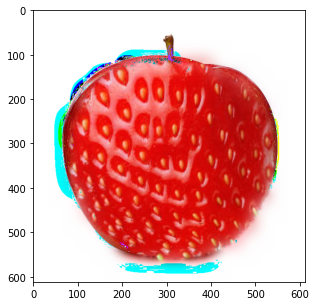

In [194]:
# Depth 5
new_img = ib.create_image(strawberry, apple, apple_mask//255, 5)
plt.imshow(((new_img[5])).astype(np.uint8));

## Experiment 4: Bird and Sky

In [195]:
# read bird image
bird = cv2.imread("drive/MyDrive/images/bird1.jpg")
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
bird = image_resizing(bird, (240,200))
bird = image_padding(bird, 408, 612 )

In [196]:
# read sky image
sky = cv2.imread("drive/MyDrive/images/sky.jpg")
sky = cv2.cvtColor(sky, cv2.COLOR_BGR2RGB)
sky = image_resizing(sky[200:,:], (612,408))

In [197]:
# read bird mask
bird_mask = cv2.imread("drive/MyDrive/images/bird_mask.jpg")
bird_mask = image_resizing(bird_mask[:,40:600],(612,408))

### Try Image Blending Operations with different Depth Levels

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


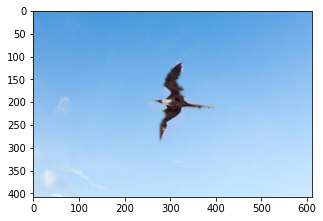

In [198]:
# Depth 2
new_img = ib.create_image(bird, sky, bird_mask//255, 2)
plt.imshow(((new_img[2])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


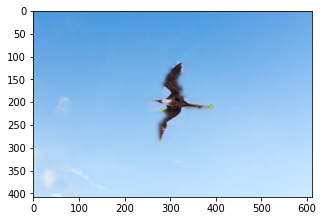

In [199]:
# Depth 3
new_img = ib.create_image(bird, sky, bird_mask//255, 3)
plt.imshow(((new_img[3])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


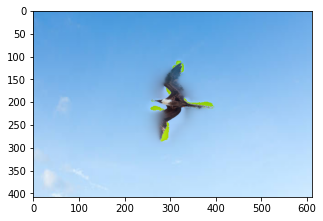

In [200]:
# Depth 5
new_img = ib.create_image(bird, sky, bird_mask//255, 5)
plt.imshow(((new_img[5])).astype(np.uint8));

## Experiment 5: Palm and Brad Pitt

In [201]:
# Brad Pitt's eye image
brad = cv2.imread("drive/MyDrive/images/brad_pitt.jpg")
brad = cv2.cvtColor(brad, cv2.COLOR_BGR2RGB)
brad = image_padding(brad[150:250, 220:330], 612, 408 )

In [202]:
# Palm image
palm = cv2.imread("drive/MyDrive/images/palm.jpg")
palm = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)

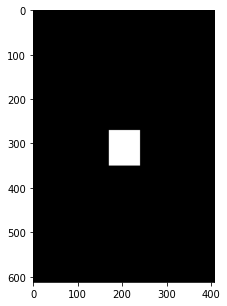

In [209]:
# Brad Pitt's Eye Mask 
brad_mask = np.zeros((612,408,3), dtype='float32')
brad_mask[270:350, 170:240 , :] = (1,1,1)
plt.imshow(brad_mask)

### Try Image Blending Operations with different Depth Levels

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


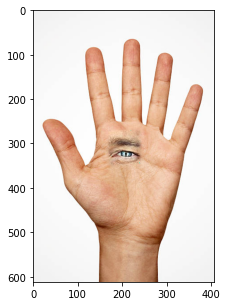

In [204]:
# Depth 2
new_img = ib.create_image(brad, palm, brad_mask, 2)
plt.imshow(((new_img[2])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


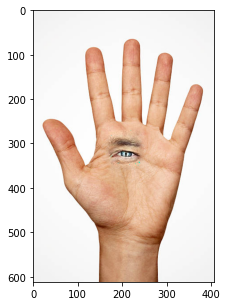

In [208]:
# Depth 3
new_img = ib.create_image(brad, palm, brad_mask, 3)
plt.imshow(((new_img[3])).astype(np.uint8));

<ipython-input-168-1116269b6b16>:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_image = np.array(new_image)


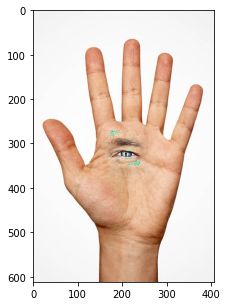

In [207]:
# Depth 4
new_img = ib.create_image(brad, palm, brad_mask, 4)
plt.imshow(((new_img[4])).astype(np.uint8));